In [1]:
from mido import MidiFile, MidiTrack, Message
import numpy as np
import mido
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
%matplotlib inline

In [2]:
def prepData(mid):
    notes = []
    time = float(0)
    prev = float(0)
    j = 1
    noteValue = []
    velValue = []
    tstamp = []
    onoff = []
    for i,msg in enumerate(mid):
        ### this time is in seconds, not ticks
        #print(j, msg)
        fmsg = msg
        time += msg.time
    # 	print (i, msg, time)
        if not msg.is_meta:
            ### only interested in piano channel
            if msg.channel > -1:
                if msg.type == 'note_on' or msg.type == 'note_off':
                    # note in vector form to train on
                    ns = 0
                    if msg.type == 'note_on':
                        ns = 1
                    else:
                        ns = 0
                    note = msg.bytes()
                    #print(j,note, time)
                    #print(fmsg)
                    # only interested in the note and velocity. note message is in the form of [type, note, velocity]
                    #print ('stage 1 ' + str(j), time - prev, note)
                    note = note[1:3]
                    #print('stage 2 ' + str(j), time - prev, note)
                    note.append(time-prev)
                    #print('stage 3 ' + str(j), time - prev, note)
                    prev = time
                    notes.append(note)
    # 				print(j, note[0], note[1], time, fmsg)
                    j = j + 1
                    noteValue.append(note[0])
                    velValue.append(note[1])
                    tstamp.append(time)
                    onoff.append(ns)    
    # print(notes)
    return noteValue, velValue, tstamp, onoff

In [3]:
# print(noteValue, velValue, tstamp)
def encoderNote(note, velocity, time, status):
    encodedNotes = []
    lastGreen = 0
    for i, t in enumerate(time):
        nnote = []
        if i == 0:
            #something - this is note starting point
            if status[i] == 1:
                #find where this note ends
                for j, n in enumerate(note):
                    if j > i:
                        if status[j] == 0 or velocity[j] == 0:
                            if note[i] == note[j]:
                                #this note ends here
                                encodedNotes.append([note[i],velocity[i], time[i], time[j]])
                                break
        else:
            #something - this is for general calculation
            if status[i] == 1:                
                #find where this note ends
                for j, n in enumerate(note):
                    if j > i:
                        if status[j] == 0 or velocity[j] == 0:
                            if note[i] == note[j]:
                                #this note ends here
                                encodedNotes.append([note[i],velocity[i], time[i] - lastGreen, time[j] - time[i]])
                                lastGreen = time[i]
                                break
    return encodedNotes

In [4]:
from sklearn.preprocessing import MinMaxScaler
def divideED(encodedNotes):
    note = []
    velocity = []
    tstamp = []
    span = []
    scaler = MinMaxScaler()
    scaler.fit(encodedNotes)
    encodedNotes = scaler.transform(encodedNotes)
    for item in encodedNotes:
        note.append(item[0])
        velocity.append(item[1])
        tstamp.append(item[2])
        span.append(item[3])
#     return note, velocity, tstamp, span, scaler
    return encodedNotes, scaler

In [5]:
def combineDD(note, scale):
    decode = []
#     for i, item in enumerate(note):
#         decode.append([note[i], velocity[i], tstamp[i], span[i]])
    decode = scale.inverse_transform(note)
    return decode

In [6]:
def decoderNote(note):
    #populate only live notes
    liveNotes = []
    tCounter = 0
    for i, n in enumerate(note):
        if i == 0:
            liveNotes.append([n[0], n[1], n[2]])
            tCounter = n[2]
        else:
            liveNotes.append([n[0], n[1], tCounter + n[2]])
            tCounter = n[2] + tCounter     
            
#     print ('livenotes: ', liveNotes)        
    #insert dead notes
    deadNotes = []
    for item in liveNotes:
        deadNotes.append(item)
#     print(len(note), len(liveNotes))
        
    for i, ln in enumerate(liveNotes):
        if i < len(note):
            start = ln[2]
            span = note[i][3]
            end =  start + span
#             print('for this livenote', i, liveNotes[i][0], liveNotes[i][1],liveNotes[i][2], start, span, end)
            for j, dn in enumerate(deadNotes):
                if j < len(deadNotes) - 1:
                    if end >= dn[2] and end <= deadNotes[j+1][2]:
                        deadNotes.insert(j + 1, [ln[0],0,end])
    #                     print('dead note for i is at ', j+1, ln[0], 0, end)
                        break
                elif j == len(deadNotes) - 1:
                    if end >= dn[2]:
                            deadNotes.insert(j + 1, [ln[0],0,end])
        #                     print('dead note for i is at ', j+1, ln[0], 0, end)
                            break
    return deadNotes

In [7]:
#create midi file with the decoded output
def createMusic(decodedNotes, name, ins):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    notes = []
   
    ch = 0
    if ins == 'drum':
        ch = 9
    elif ins == 'piano':
        ch = 0
    
    for i, note in enumerate(decodedNotes):
        if i > 0:
            notes.append([decodedNotes[i][0], decodedNotes[i][1], decodedNotes[i][2] - decodedNotes[i-1][2]])
        else:
            notes.append(note)
#     print(notes)
    for i, note in enumerate(notes):        
            note = np.insert(note, 0, 147)
            bytes = note.astype(int)
            msg = Message.from_bytes(bytes[0:3])
            #time = int(note[3]/0.001025) # to rescale to midi's delta ticks. arbitrary value for now.
            time = int(note[3]/0.001025)
            msg.channel = ch
            msg.time = time
#             print (i, msg)
            track.append(msg)
    mid.save(name + '.mid')

In [8]:
def createRNNData_seq(notes, n_prev):
    X = []
    Y = []
#     n_prev = 30
    # n_prev notes to predict the (n_prev+1)th note
    for i in range(len(notes)-n_prev):
        x = notes[i:i+n_prev]
        y = notes[i+1:i+n_prev+1]
        X.append(x)
        Y.append(y)
    # save a seed to do prediction later
    seed = notes[0:n_prev]
    return X, Y

In [9]:
def deScale(prediction):
    for pred in prediction:
#         pred[0] = int(88*pred[0] + 24)
        pred[0] = int(pred[0])
        pred[1] = int(pred[1])
        # to reject values that will be out of range
        if pred[0] < 24:
            pred[0] = 24
        elif pred[0] > 102:
            pred[0] = 102
            
        if pred[1] < 0:
            pred[1] = 0
        elif pred[1] > 127:
            pred[1] = 127
            
        if pred[2] < 0:
            pred[2] = 0
        if pred[3] < 0:
            pred[3] = 0
    return prediction

In [10]:
def getDataFiles(dir_name, nSongs):
    onlyfiles = [f for f in listdir('./train/') if isfile(join('./train/', f))]
#     print(onlyfiles)
    notes_lib = []
    for i, filename in enumerate(onlyfiles):
        if i < nSongs:
            mid = MidiFile('./train/'+filename)
            note, velocity, time, onoff = prepData(mid)
            encodedNotes = encoderNote(note, velocity, time, onoff)
            for item in encodedNotes:
                notes_lib.append(item)
    return notes_lib

In [11]:
training_data_set = getDataFiles('./train/', 50)
# print(training_data_set[0:50])

[[76, 105, 0.0, 0.49895833333333334], [74, 105, 0.5, 0.9989583333333334], [55, 75, 0.0, 1.4989583333333334], [59, 75, 0.0, 1.4989583333333334], [62, 75, 0.0, 1.4989583333333334], [71, 80, 1.0, 0.4989583333333334], [69, 105, 0.5, 0.7489583333333334], [50, 75, 0.0, 1.4989583333333334], [54, 75, 0.0, 1.4989583333333334], [57, 75, 0.0, 1.4989583333333334], [71, 80, 0.75, 0.2489583333333334], [72, 80, 0.25, 0.4989583333333334], [71, 105, 0.5, 0.9989583333333334], [55, 75, 0.0, 1.4989583333333334], [59, 75, 0.0, 1.4989583333333334], [62, 75, 0.0, 1.4989583333333334], [67, 80, 1.0, 0.4989583333333334], [69, 105, 0.5, 0.9989583333333334], [50, 75, 0.0, 1.4989583333333334], [54, 75, 0.0, 1.4989583333333334], [57, 75, 0.0, 1.4989583333333334], [76, 80, 1.0, 0.4989583333333334], [74, 105, 0.5, 0.9989583333333334], [55, 75, 0.0, 1.4989583333333334], [59, 75, 0.0, 1.4989583333333334], [62, 75, 0.0, 1.4989583333333334], [71, 80, 1.0, 0.4989583333333334], [69, 105, 0.5, 0.7489583333333325], [50, 75, 

In [12]:
#create rationalized data set
def ratNotes(training_data_set):
    rat_notes = []
    notes = [0 for i in range(91)]
    more2come = 0
    for i, note in enumerate(training_data_set):
        if i < len(training_data_set) - 1:
            if training_data_set[i+1][2] > 0:
                #do something
                notes[note[0] - 24] = 1
                notes[88] = note[1]
                notes[89] = note[2]
                notes[90] = note[3]
                more2come = 0
            else:
                #add to the current notes
                if note[2] > 0 and note[1] == training_data_set[i+1][1]:
                    notes[note[0] - 24] = 1
                    notes[88] = note[1]
                    notes[89] = note[2]
                    notes[90] = note[3]
                    more2come = 1
                else:
                    if training_data_set[i+1][2] == 0 and training_data_set[i][2] == 0 and training_data_set[i+1][1] == training_data_set[i][1]:
                        if training_data_set[i+1][3] == training_data_set[i][3]:
                            notes[note[0] - 24] = 1
                            notes[88] = note[1]
                            notes[89] = note[2]
                            notes[90] = note[3]
                            more2come = 1
                        else:
                            notes[note[0] - 24] = 1
                            notes[88] = note[1]
                            notes[89] = note[2]
                            notes[90] = note[3]
                            more2come = 0
                    else:
                        notes[note[0] - 24] = 1
                        notes[88] = note[1]
                        notes[89] = note[2]
                        notes[90] = note[3]
                        more2come = 0           

            if more2come == 0:           
                rat_notes.append(notes)
                notes = [0 for i in range(91)]
                more2come = 0
            else:
                pass

    return rat_notes
# for i, note in enumerate(rat_notes):
#     if i < 10:
#         print(note)

In [13]:
#de_rat notes
# rat_notes = ratNotes(training_data_set)
# print(rat_notes[0:5])

def unratNotes(rat_notes):
    unrat_notes = []
    for note in rat_notes:
        for i, item in enumerate(note):        
            if i < 88:
                if item > 0:
                    newNote = i + 24
                    unrat_notes.append([newNote, int(note[88]), note[89], note[90]])
    return unrat_notes
# print(unrat_notes[0:10])

In [14]:
scaled_notes, scaler = divideED(ratNotes(training_data_set))
# print(scaled_notes[1:5])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.25
  0.32155477]
 [0.         0.         0.         0.         0.         0.
  0.         0.         

In [75]:
tf.reset_default_graph()
# Just one feature, the time series
num_inputs = 91
# 100 neuron layer, play with this
num_neurons = 512
# Just one output, predicted time series
num_outputs = 91
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0003
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 500
# Size of the batch of data

batch_size = 1
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 3
n_layers = 8
n_neurons = num_neurons

In [16]:
X_batch, y_batch = createRNNData_seq(scaled_notes, num_time_steps)
# print(X_batch[0], y_batch[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.15194346]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.

In [76]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons)])
# cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_units=num_neurons) for i in range(n_layers)])
#last used
cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_units=num_neurons), tf.contrib.rnn.LSTMCell(num_units=num_neurons), tf.contrib.rnn.LSTMCell(num_units=num_neurons)])
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
# loss = tf.reduce_mean(tf.abs(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [18]:
# y_pred = []
# music = []
# seed_in = []

# with tf.Session() as sess:
#     sess.run(init)    
#     for iteration in range(num_train_iterations):        
# #         X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
#         sess.run(train, feed_dict={X: X_batch, y: y_batch})        
#         if iteration % 10 == 0:            
#             mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
#             print(iteration, "\tMSE:", mse)
#     # Save Model for Later
#     saver.save(sess, "./lstm_new")
#     seed = np.array(X_batch[100]).reshape(1, num_time_steps, 91)
#     for iteration in range(5):        
#         y_out = sess.run(outputs, feed_dict={X: seed})
#         y_pred.append(y_out)
#         seed_in.append(seed)
#         print('input ', seed)
#         print('pred ', y_out)
#         music.append(y_out)
#         seed = y_out

0 	MSE: 0.01785456
10 	MSE: 0.016002275
20 	MSE: 0.015592786
30 	MSE: 0.015179991
40 	MSE: 0.014784878
50 	MSE: 0.014413309
60 	MSE: 0.0140272435
70 	MSE: 0.0137011735
80 	MSE: 0.013551141
90 	MSE: 0.013445261
100 	MSE: 0.013351131
110 	MSE: 0.013256352
120 	MSE: 0.013163318
130 	MSE: 0.013082202
140 	MSE: 0.013017262
150 	MSE: 0.01296127
160 	MSE: 0.012910432
170 	MSE: 0.012862377
180 	MSE: 0.01281514
190 	MSE: 0.012766848
200 	MSE: 0.012717212
210 	MSE: 0.012664623
220 	MSE: 0.012608586
230 	MSE: 0.012548446
240 	MSE: 0.012483906
250 	MSE: 0.0124134505
260 	MSE: 0.012335615
270 	MSE: 0.012247639
280 	MSE: 0.01214747
290 	MSE: 0.012035419
input  [[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         1.         0.         0.  

In [77]:
# # #Generating New Sequences from saved model
y_pred = []
music = []
seed_in = []
full_notes = []
new_notes = []
with tf.Session() as sess:
    saver.restore(sess, "./lstm_new")
    
    seed = np.array(X_batch[1200]).reshape(1, num_time_steps, 91)
    music.append(seed)
    
    for item in seed:
        for note in item:
            new_notes.append(note)
    
#     seed = np.array(X_batch).reshape(1, num_time_steps, 4)
    for iteration in range(5):        
        y_out = sess.run(outputs, feed_dict={X: seed})
        new_note = y_out[0][num_time_steps - 1]
                
        y_pred.append(y_out)
        seed_in.append(seed)
#         print('input ', seed)
#         print('pred ', y_out)
        music.append(new_note)
        new_notes.append(new_note)
        full_notes.append(new_note)
        if len(new_notes) > 3:
            lt = len(new_notes)
            seed = [[new_notes[lt-3],new_notes[lt-2],new_notes[lt-1]]]
        else:
            seed = [[seed[0][1],seed[0][2],new_note]]

INFO:tensorflow:Restoring parameters from ./lstm_new


In [78]:
# seed = np.array(X_batch[10]).reshape(1, num_time_steps, 4)
# print(seed)
# print(y_out)
music = []
for item in full_notes:
#     print(item)
    music.append(item)
    #         print(note)
# print(music)
# print(y_pred)
# print(seed_in)

In [79]:
decode = combineDD(music, scaler)
# print(decode)

In [80]:
# print(decode)
clubthis = [x for x in decode]
# print(clubthis)
for item in clubthis:    
    for j, code in enumerate(item):
#         print(j, code)
        if j < 88:
            if code < 0.1:
#                 print(item[j])
                item[j] = 0
            else:
                item[j] = 1
              
               
# print(clubthis)        

In [81]:
muzik = unratNotes(decode)
# print(muzik)

In [82]:
cleanseNotes = deScale(muzik)
# print(cleanseNotes[0:10])

In [68]:
#basic cleansing
#correct time elements through clustering
# Fitting K-Means to the dataset
from sklearn.cluster import KMeans
#data set for clustering
X = [[x[2], x[3]] for x in training_data_set]
kmeans = KMeans(n_clusters = 50, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
centroid = kmeans.cluster_centers_

In [83]:
#align with clusters
for item in cleanseNotes:
    x_sample = [[item[2], item[3]]]
    y_pred_c = kmeans.predict(x_sample)
    cluster = y_pred_c[0]
    item[2] = centroid[cluster][0]
    item[3] = centroid[cluster][1]

#NORMALIZE
for item in cleanseNotes:
    item[0] = int(item[0])
    item[1] = int(item[1])
    if item[2] < 0.1:
        item[2] = 0
        
# print(cleanseNotes[0:10])

[[70, 87, 0.16040388548057233, 0.4989583333333344], [72, 87, 0.16040388548057233, 0.4989583333333344], [74, 87, 0.16040388548057233, 0.4989583333333344], [69, 84, 0.37500000000000006, 0.49895833333333395], [70, 84, 0.37500000000000006, 0.49895833333333395], [72, 84, 0.37500000000000006, 0.49895833333333395], [74, 84, 0.37500000000000006, 0.49895833333333395], [69, 89, 0.24941389599318003, 0.4989583333333345], [70, 89, 0.24941389599318003, 0.4989583333333345], [72, 89, 0.24941389599318003, 0.4989583333333345]]


In [84]:
decoded = decoderNote(cleanseNotes)
# print(decoded[0:20])

In [85]:
createMusic(decoded, 'piano_2_adj', 'piano')
createMusic(decoded, 'drum_2_adj', 'drum')
# createMusicF(decoded, 'genesis_join_1', 'drum')
# createMusic(decoded, 'genesis_drum_something_5adj', 'drum')

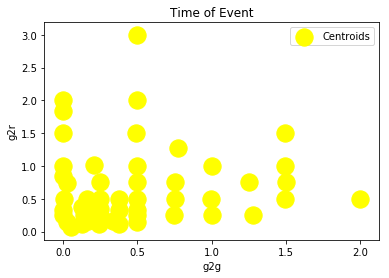

In [72]:
# Visualising the clusters
import matplotlib.pyplot as plt
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Time of Event')
plt.xlabel('g2g')
plt.ylabel('g2r')
plt.legend()
plt.show()

## Author

Mohneesh Saxena
- https://www.linkedin.com/in/mohneesh-saxena-33243616
- https://twitter.com/mohneesh.saxena
- https://github.com/mohneesh-saxena/

## License

This project is free to use according to the [MIT License]